In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from yellowbrick.classifier import ROCAUC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data 
test = pd.read_csv('data/Case2_Test Set Template.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 1 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Month Year;Mapped_GCK;Sales_EUR  140 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


In [3]:
df = pd.read_csv('data/Case2_Sales data.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [4]:
Macro = pd.read_csv('data/Case2_Market data.csv', delimiter=';')
Macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           221 non-null    object 
 1   China                221 non-null    object 
 2   China.1              221 non-null    object 
 3   France               221 non-null    object 
 4   France.1             221 non-null    object 
 5   Germany              221 non-null    object 
 6   Germany.1            221 non-null    object 
 7   Italy                221 non-null    object 
 8   Italy.1              221 non-null    object 
 9   Japan                221 non-null    object 
 10  Japan.1              221 non-null    object 
 11  Switzerland          220 non-null    object 
 12  Switzerland.1        220 non-null    object 
 13  United Kingdom       221 non-null    object 
 14  United Kingdom.1     203 non-null    object 
 15  United States        221 non-null    obj

In [5]:
df.describe(include='object').T

,count,unique,top,freq
DATE,9802,1216,30.09.2019,14
Mapped_GCK,9802,14,#1,1179
Sales_EUR,9802,2609,0,7134


In [6]:
df.describe().T

,count,unique,top,freq
DATE,9802,1216,30.09.2019,14
Mapped_GCK,9802,14,#1,1179
Sales_EUR,9802,2609,0,7134


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [8]:
df.shape

(9802, 3)

In [9]:
df.head(3)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0


In [10]:
# Loop through each column in the DataFrame
for column in df.columns:
    
    # Check if the number of unique values in the column is less than 20
    if df[column].nunique() < 20:
        
        print(f"Unique values in '{column}': {df[column].unique()}")
        print(f"Number of unique values: {df[column].nunique()}\n")

Unique values in 'Mapped_GCK': ['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']
Number of unique values: 14



## Exploratory Data Analysis (EDA)
Before creating lag features, let's visualize the data to understand trends and patterns.

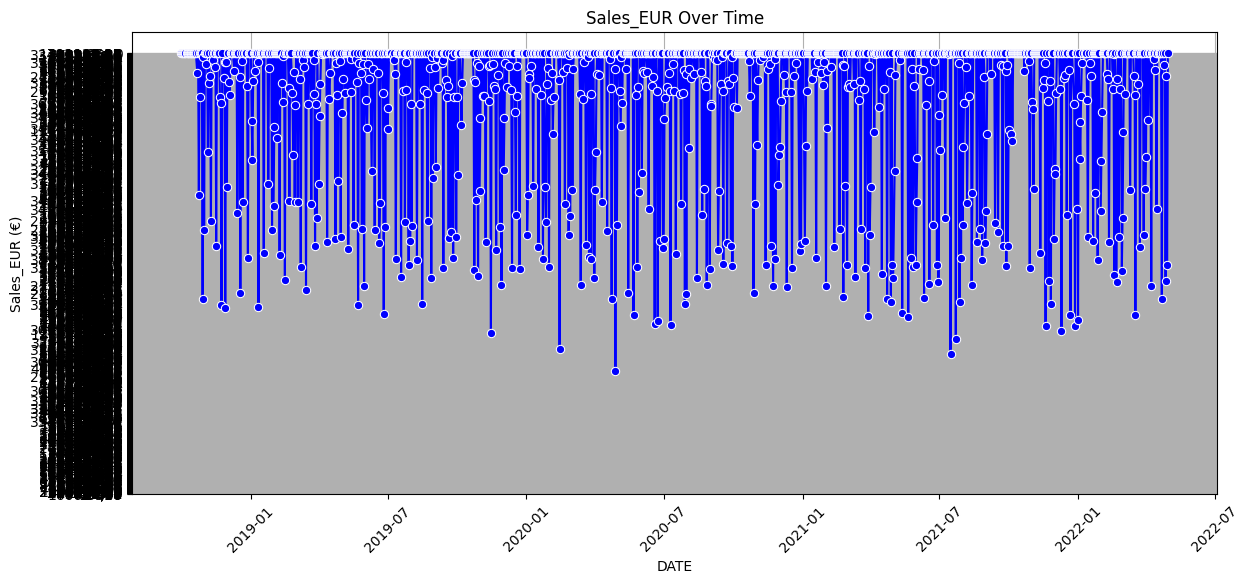

In [11]:

# Convert DATE column to datetime if not already
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)

# Plot Sales_EUR over time
plt.figure(figsize=(14,6))
sns.lineplot(x=df['DATE'], y=df['Sales_EUR'], marker='o', color='b')
plt.title('Sales_EUR Over Time')
plt.xlabel('DATE')
plt.ylabel('Sales_EUR (€)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


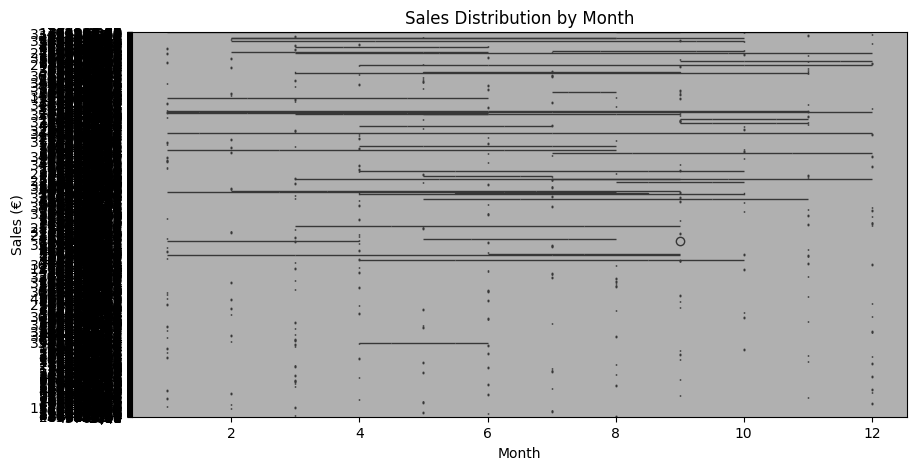

In [12]:

# Sales_EUR seasonality by month
df['month'] = df['DATE'].dt.month
plt.figure(figsize=(10,5))
sns.boxplot(x=df['month'], y=df['Sales_EUR'], palette='coolwarm')
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Sales (€)')
plt.grid()
plt.show()


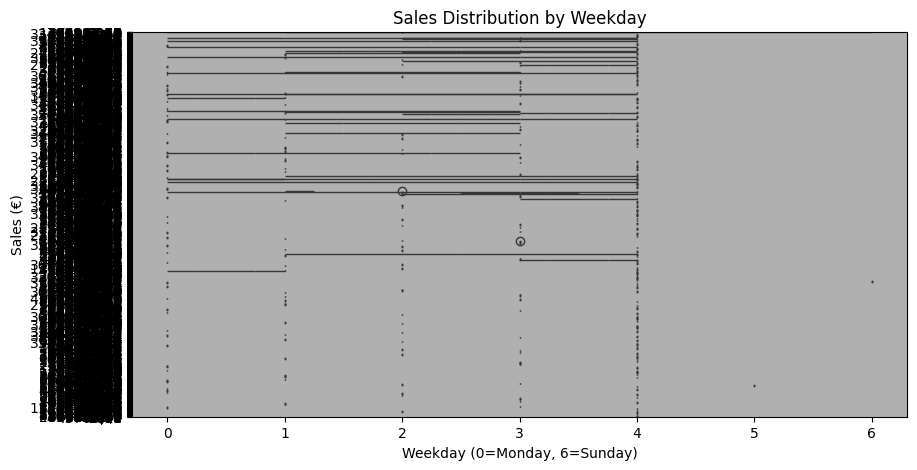

In [13]:
# Sales_EUR seasonality by weekday
df['weekday'] = df['DATE'].dt.weekday
plt.figure(figsize=(10,5))
sns.boxplot(x=df['weekday'], y=df['Sales_EUR'], palette='coolwarm')
plt.title('Sales Distribution by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Sales (€)')
plt.grid()
plt.show()


In [14]:
print(df.columns)
print(Macro.columns)

Index(['DATE', 'Mapped_GCK', 'Sales_EUR', 'month', 'weekday'], dtype='object')
Index(['Unnamed: 0', 'China', 'China.1', 'France', 'France.1', 'Germany',
       'Germany.1', 'Italy', 'Italy.1', 'Japan', 'Japan.1', 'Switzerland',
       'Switzerland.1', 'United Kingdom', 'United Kingdom.1', 'United States',
       'United States.1', 'Europe', 'Europe.1', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Producer Prices', 'Producer Prices.1',
       'Producer Prices.2', 'Producer Prices.3', 'Producer Prices.4',
       'Producer Prices.5', 'production index', 'production index.1',
       'production index.2', 'production index.3', 'production index.4',
       'production index.5', 'production index.6', 'production index.7',
       'production index.8', 'production index.9', 'production index.10',
       'production index.11', 'production index.12', 'production index.13',
       'production index.14', 'production index.15

In [15]:
# # Rename columns for consistency
# df.rename(columns={'DATE': 'date'}, inplace=True)
# Macro.rename(columns={'date': 'date'}, inplace=True)  # Ensures consistency

# # Correlation heatmap between Sales_EUR and macro factors
# df_corr = df.merge(Macro, on='date', how='left')  # Merging with macro data
# corr = df_corr.corr()

# plt.figure(figsize=(12,6))
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("Correlation Heatmap")
# plt.show()


## Post-Lag Feature EDA

Non-numeric columns: Index(['DATE', 'Mapped_GCK'], dtype='object')


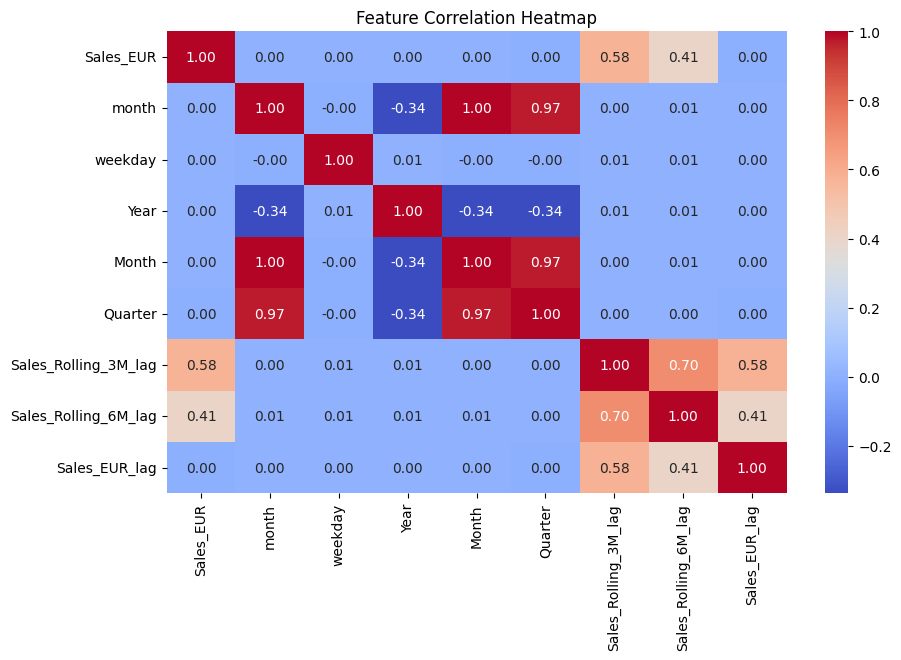

,DATE,Mapped_GCK,Sales_EUR,month,weekday,Year,Month,Quarter,Sales_Rolling_3M_lag,Sales_Rolling_6M_lag,Sales_EUR_lag
0,2018-10-01,#1,0.0,10,0,2018,10,4,NaN,NaN,NaN
8398,2018-10-01,#16,0.0,10,0,2018,10,4,NaN,NaN,0.0
410,2018-10-01,#11,0.0,10,0,2018,10,4,0.0,NaN,0.0


In [19]:
# Assuming your Sales_EUR data is in a DataFrame called df
# Ensure DATE column is in DATEtime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df = df.sort_values(by='DATE')

# Feature Engineering: Time-based features
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Quarter'] = df['DATE'].dt.quarter

# Convert Sales_EUR to numeric if not already
df['Sales_EUR'] = df['Sales_EUR'].astype(str).str.replace(',', '.').astype(float)

# Lag features: Previous month's sales
df['Sales_EUR_lag'] = df['Sales_EUR'].shift(1)

# Rolling averages
df['Sales_Rolling_3M_lag'] = df['Sales_EUR'].rolling(window=3).mean()
df['Sales_Rolling_6M_lag'] = df['Sales_EUR'].rolling(window=6).mean()

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Drop non-numeric columns before correlation
df_numeric = df.drop(columns=non_numeric_cols)

# Plot heatmap with numeric data
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

df.head(3)

In [18]:
drop_cols = ['Sales_EUR_Lag']
df.drop(drop_cols, axis=1, inplace=True)

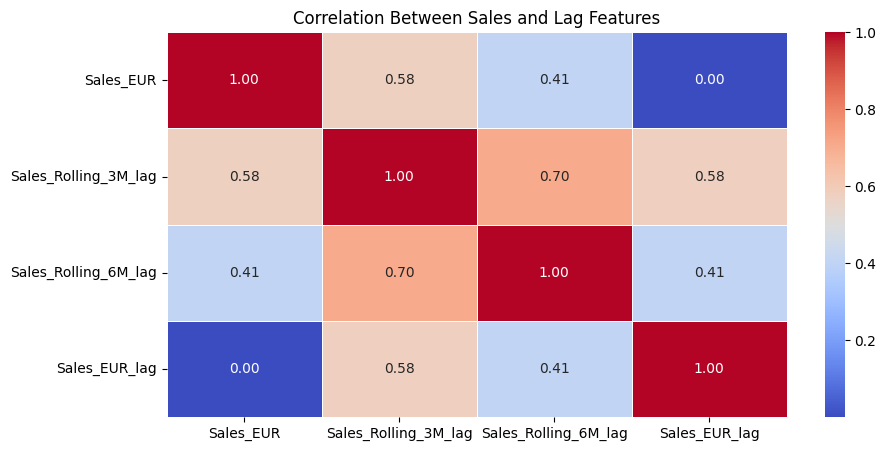

In [20]:
# Checking the correlation between lag features and Sales_EUR
lag_features = [col for col in df.columns if '_lag' in col]  # Assuming lag features are named with 'lag'

# Ensure Sales_EUR and lag features are numeric
df['Sales_EUR'] = df['Sales_EUR'].astype(str).str.replace(',', '.').astype(float)

# Convert lag features to numeric format
for col in lag_features:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Now calculate correlation
corr_lag = df[['Sales_EUR'] + lag_features].corr()

# Plot the heatmap
plt.figure(figsize=(10,5))
sns.heatmap(corr_lag, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Sales and Lag Features")
plt.show()


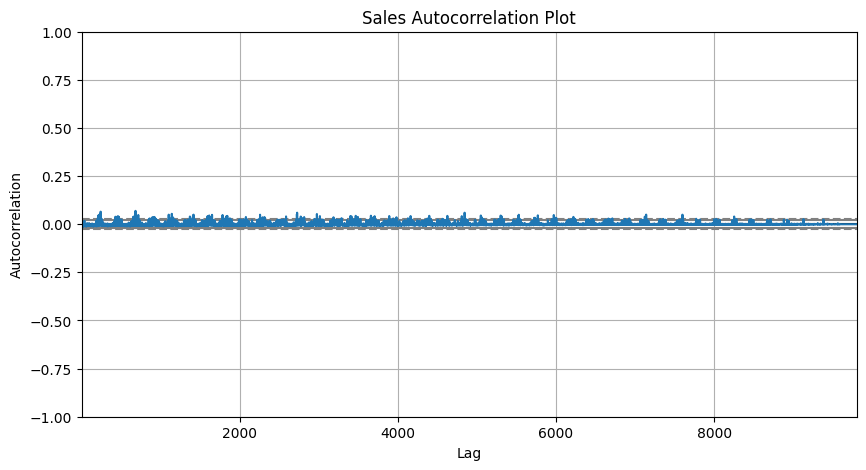

In [21]:

# Autocorrelation plot to check lag strength
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(df['Sales_EUR'])
plt.title("Sales Autocorrelation Plot")
plt.show()


In [22]:
print(df.isnull().sum())

DATE                    0
Mapped_GCK              0
Sales_EUR               0
month                   0
weekday                 0
Year                    0
Month                   0
Quarter                 0
Sales_Rolling_3M_lag    2
Sales_Rolling_6M_lag    5
Sales_EUR_lag           1
dtype: int64


array([[<Axes: title={'center': 'Sales_EUR'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'weekday'}>],
       [<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Quarter'}>],
       [<Axes: title={'center': 'Sales_Rolling_3M_lag'}>,
        <Axes: title={'center': 'Sales_Rolling_6M_lag'}>,
        <Axes: title={'center': 'Sales_EUR_lag'}>],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

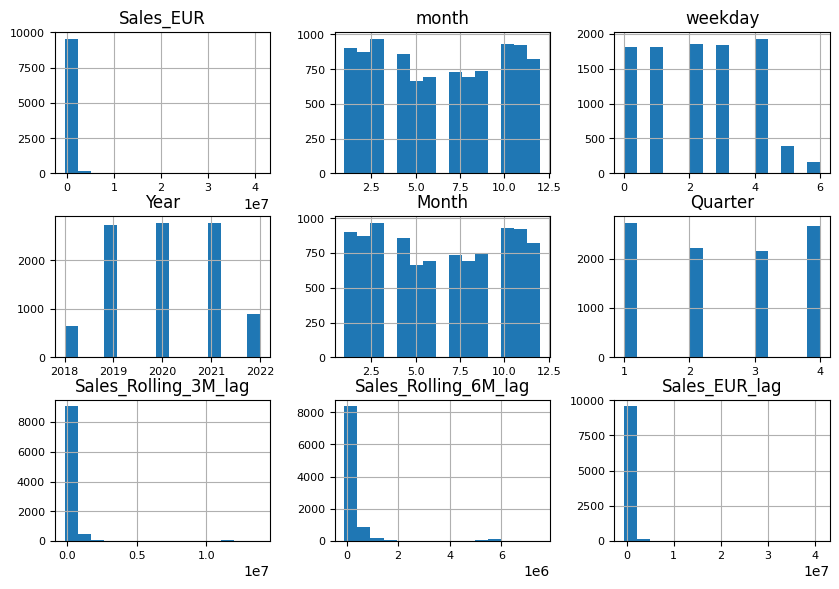

In [23]:
numerical=df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical].hist(bins=15, figsize=(10, 9), layout=(4, 3), xlabelsize=8, ylabelsize=8)

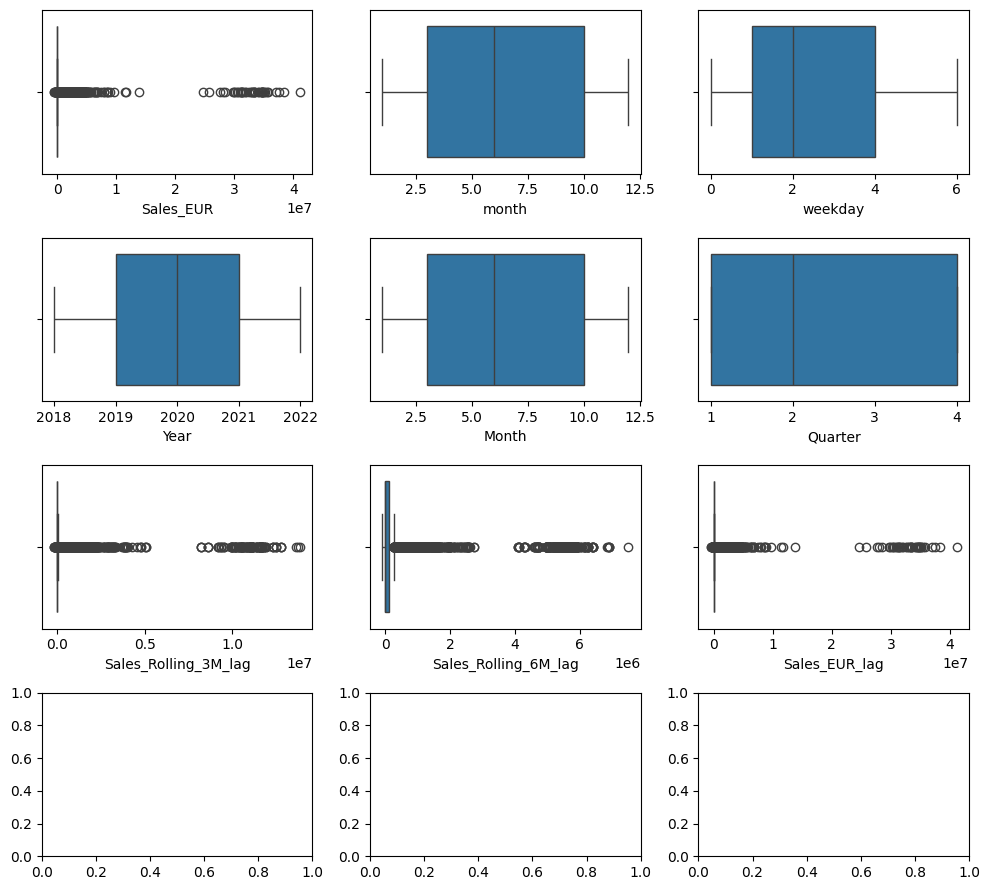

In [24]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(4, 3, figsize=(10, 9))
for var, subplot in zip(df[numerical], ax.flatten()):
    sns.boxplot(x=df[var], ax=subplot)
plt.tight_layout()
plt.show()

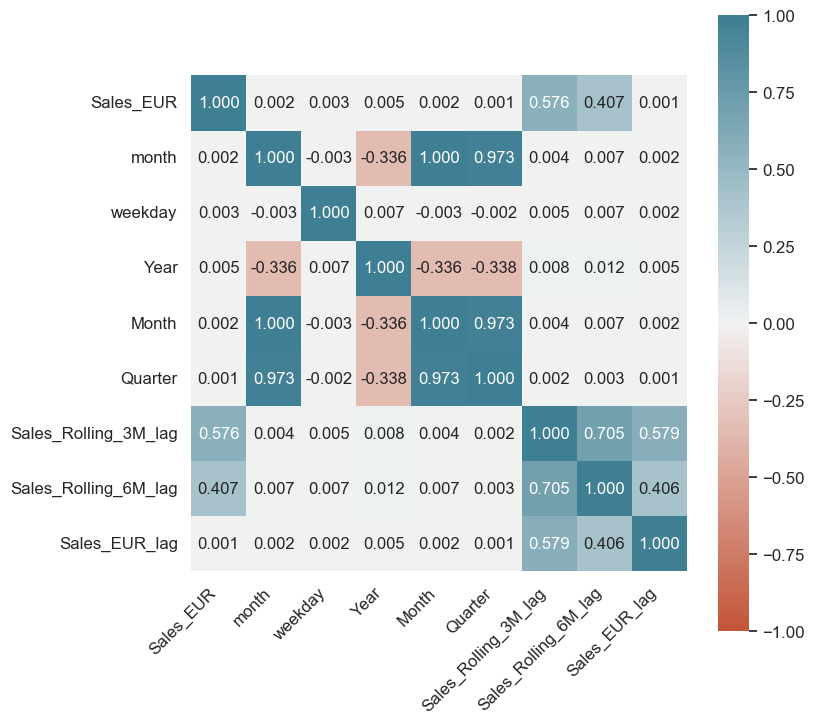

In [25]:
# Plot correlation heatmap of all numeric variables
corr = df[numerical].corr()
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12},
    fmt='.3f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);